In [ ]:
%pip install d2l==1.0.0a0

In [17]:
import os
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from d2l import torch as d2l

# Dataset

In [3]:
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

In [4]:
def read_voc_images(voc_dir, is_train=True):
    """Read all VOC feature and label images."""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)

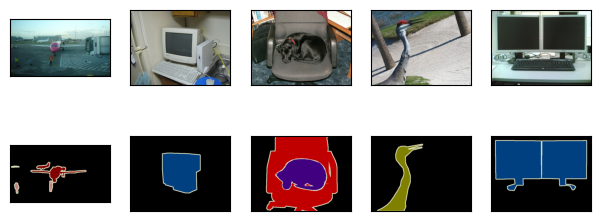

In [5]:
n = 5
imgs = train_features[:n] + train_labels[:n]
imgs = [img.permute(1,2,0) for img in imgs]
d2l.show_images(imgs, 2, n);

In [6]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [7]:
def voc_colormap2label():
    """Build the mapping from RGB to class indices for VOC labels."""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

def voc_label_indices(colormap, colormap2label):
    """Map any RGB values in VOC labels to their class indices."""
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

In [8]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

## Data Preparation
Unline classification where we could easily resize the image to fir the network input, here this will cause artifact and cause issues with labels. instead we will crop the images.

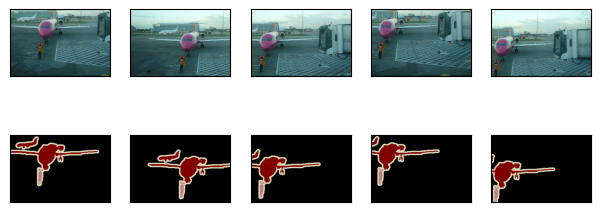

In [9]:
def voc_rand_crop(feature, label, height, width):
    """Randomly crop both feature and label images."""
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

In [10]:
class VOCSegDataset(torch.utils.data.Dataset):
    """A customized dataset to load the VOC dataset."""

    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

In [11]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [12]:
batch_size = 64
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True,
                                    drop_last=True,
                                    num_workers=d2l.get_dataloader_workers())
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


Putting all together.

In [13]:
def load_data_voc(batch_size, crop_size):
    """Load the VOC semantic segmentation dataset."""
    voc_dir = d2l.download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True, num_workers=num_workers)
    return train_iter, test_iter

In [15]:
def trans_conv(X, K):
    h, w = K.shape
    out = torch.zeros((X.shape[0]+ h-1, X.shape[1] + w - 1))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            out[i:i+h, j:j+w] += X[i, j] * K
    return out

X = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
trans_conv(X, K)

tensor([[ 0.,  0.,  1.],
        [ 0.,  4.,  6.],
        [ 4., 12.,  9.]])

# Model
We use a ResNet18 for the CNN part.

In [16]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 128MB/s]


[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [18]:
# Discard the adaptiveavgpool and FC layer at the end
net = nn.Sequential(*list(pretrained_net.children())[:-2])

In [19]:
# /32 size reduction
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

We need to upsample by 32x. One way to do is with one trans conv layer. We choose kernel=64, padding=16, and stride=32, $(320-64 +2 \times 16+32)/32=10$ and $(480-64+2\times 16+32)/32=15$.

In [20]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))